In [2]:
from utils.paths_to_files import *
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
import IPython.display as ipd
from utils.utils import *
from utils.classificationEvaluation import *
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# 1. Defining the task and splitting the data

The goal is to use the KNN classifier to determine the genre in which a certain track belongs to.
Considering the dense numerical nature of our dataset, the most suitable distance measure for the KNN algorithm would likely be the Euclidean distance.  The only issue is that our dataset is highly dimensional, and the Euclidean distance can suffer from the curse of dimensionality.
At first, we will explore how "dense" the data is, by analyzing the distribution of the smallest and average distances between any two points.

In [3]:
df = pd.read_csv(FEATURES_PATH_PROCESSED, index_col=0, header=[0, 1, 2])

# Genre column has no inner levels
df = df.rename(columns={'Unnamed: 253_level_1': '', 'Unnamed: 253_level_2' : ''})

Subsampling to reduce execution time (in the final project, the whole dataset will be used)

In [4]:
rock_rows = df[df['genre'] == 'Rock'].sample(3000, random_state=22).index
electronic_rows = df[df['genre'] == 'Electronic'].sample(2500, random_state=22).index
df = df[~df.index.isin(rock_rows)]
df = df[~df.index.isin(electronic_rows)]
df = df.sample(14000, random_state=22)

In [5]:
df['genre'].value_counts()

Rock                   3225
Electronic             2566
Experimental           2144
Hip-Hop                1735
Folk                   1138
Pop                     893
Instrumental            802
International           482
Classical               275
Jazz                    235
Old-Time / Historic     135
Spoken                   98
Soul-RnB                 98
Country                  91
Blues                    68
Easy Listening           15
Name: genre, dtype: int64

In [6]:
train_set, test_set = train_test_split(df, train_size=0.8, stratify=df['genre'], random_state=123)

train_set_indexes = train_set.index
test_set_indexes = test_set.index

In [7]:
# We select only spectral_centroid because of the high correlation with spectral_bandwidth and spectral_rolloff
slice_1 = pd.IndexSlice[['mfcc', 'spectral_centroid', 'spectral_contrast', 'rmse', 'tonnetz', 'zcr']]

# Select all features of chroma_cqt, except max (most of the values are 1s)
slice_2 = pd.IndexSlice['chroma_cqt', ('kurtosis', 'mean', 'median', 'min', 'skew', 'std')]
df_1 = pd.concat([df.loc[:, slice_1], df.loc[:, slice_2]], axis=1).copy()

Since we will be using the Euclidean distance, brining the features of the dataset to the same scale is required

In [8]:
def scale_features(train_X, test_X, scaler):
    train_X = pd.DataFrame(scaler.fit_transform(train_X), index=train_X.index, columns=train_X.columns)
    test_X = pd.DataFrame(scaler.transform(test_X), index=test_X.index, columns=test_X.columns)

    return train_X, test_X

In [9]:
from sklearn.preprocessing import MinMaxScaler

train_X = df_1.loc[train_set_indexes, :]
train_y = df.loc[train_set_indexes, 'genre']

test_X = df_1.loc[test_set_indexes, :]
test_y = df.loc[test_set_indexes, 'genre']

In [10]:
train_X_1, test_X_1 = scale_features(train_X, test_X, MinMaxScaler())

# 2. Inspecting the pairwise distances

In [11]:
distances_train = pd.DataFrame(pairwise_distances(train_X_1, metric='euclidean', n_jobs=-1), index=train_X_1.index, columns=train_X_1.index)

In [12]:
distances_test = pd.DataFrame(pairwise_distances(test_X_1, train_X_1, metric='euclidean', n_jobs=-1), index=test_X_1.index, columns=train_X_1.index)

In [13]:
avg_dist_distribution = pd.Series(distances_train.mean(axis=1))
avg_dist_distribution.describe()

count    11200.000000
mean         2.425044
std          0.264898
min          1.943788
25%          2.233637
50%          2.378471
75%          2.565003
max          4.842572
dtype: float64

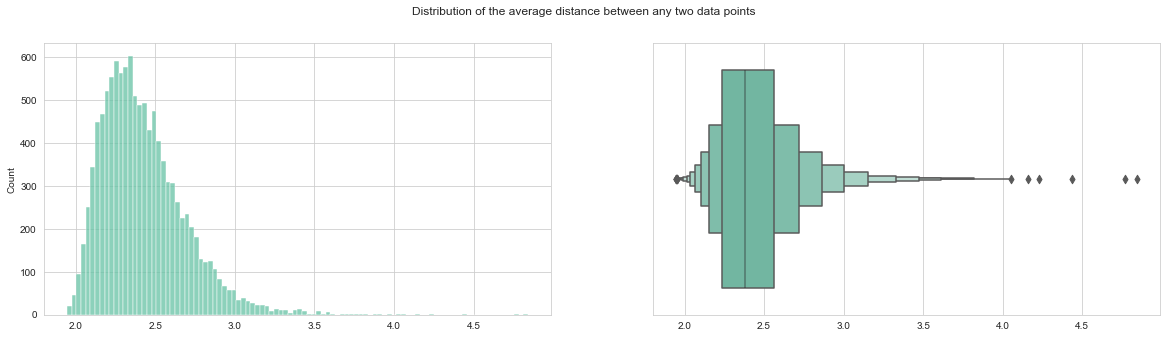

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(data=avg_dist_distribution, ax=axs[0])
sns.boxenplot(x=avg_dist_distribution, ax=axs[1])
fig.suptitle('Distribution of the average distance between any two data points')
plt.show()

In [15]:
# the distance from an input vector to itself is 0
distances_diagonal_inf = distances_train.copy()
np.fill_diagonal(distances_diagonal_inf.values, np.inf)

In [16]:
min_dist_distribution = pd.Series(distances_diagonal_inf.min(axis=1))
min_dist_distribution.describe()

count    11200.000000
mean         1.404063
std          0.274827
min          0.000000
25%          1.239124
50%          1.377447
75%          1.548983
max          3.519848
dtype: float64

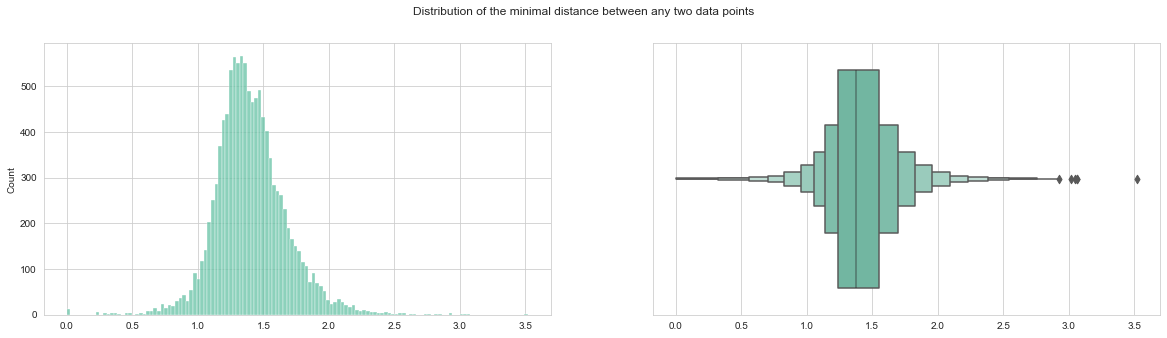

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(data=min_dist_distribution, ax=axs[0])
sns.boxenplot(x=min_dist_distribution, ax=axs[1])
fig.suptitle('Distribution of the minimal distance between any two data points')
plt.show()

# 3. Training the classifiers on the original features

The Genre 'Easy Listening' is underrepresented (only 12 tracks belong to this genre) and hence the K parameter in our KNN classifier should roughly be around 10.
We will experiment with different values

In [20]:
train_y.value_counts().sort_values()[:3]

Easy Listening    12
Blues             54
Country           73
Name: genre, dtype: int64

In [21]:
model_evaluations = {}
for i in range(7, 17):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed')
    knn.fit(distances_train, train_y)

    me = ClassificationEvaluation(
        model_name=f'model_{i}',
        model=knn,
        train_X=distances_train,
        train_y=train_y,
        val_X=distances_test,
        val_y=test_y
    )

    model_evaluations[f'model_{i}'] = me

In [24]:
def get_train_test_results(model_evaluations, average_type):
    train_set_results = pd.DataFrame()
    test_set_results = pd.DataFrame()
    num_neighbors = []
    for name, model_eval in model_evaluations.items():
        train_scores = model_eval.get_scores(on_sets=['train'], average_type=average_type)
        train_scores.columns = [f'{model_eval.model.n_neighbors}']
        train_set_results = pd.concat([train_set_results, train_scores], axis=1)

        test_scores = model_eval.get_scores(on_sets=['validation'], average_type=average_type)
        test_scores.columns = [f'{model_eval.model.n_neighbors}']
        test_set_results = pd.concat([test_set_results, test_scores], axis=1)

        num_neighbors.append(str(model_eval.model.n_neighbors))

    return train_set_results, test_set_results, num_neighbors

def results_long_format(results):
    results = results.reset_index()
    results = results.rename(columns={'index': 'metric'})
    results = pd.melt(results, id_vars=['metric'], value_vars=num_neighbors)
    results = results.rename(columns={'variable': '# neighbors'})
    return results

In [23]:
train_set_results, test_set_results, num_neighbors = get_train_test_results(model_evaluations, average_type='weighted')

In [25]:
train_set_results = results_long_format(train_set_results)
test_set_results = results_long_format(test_set_results)

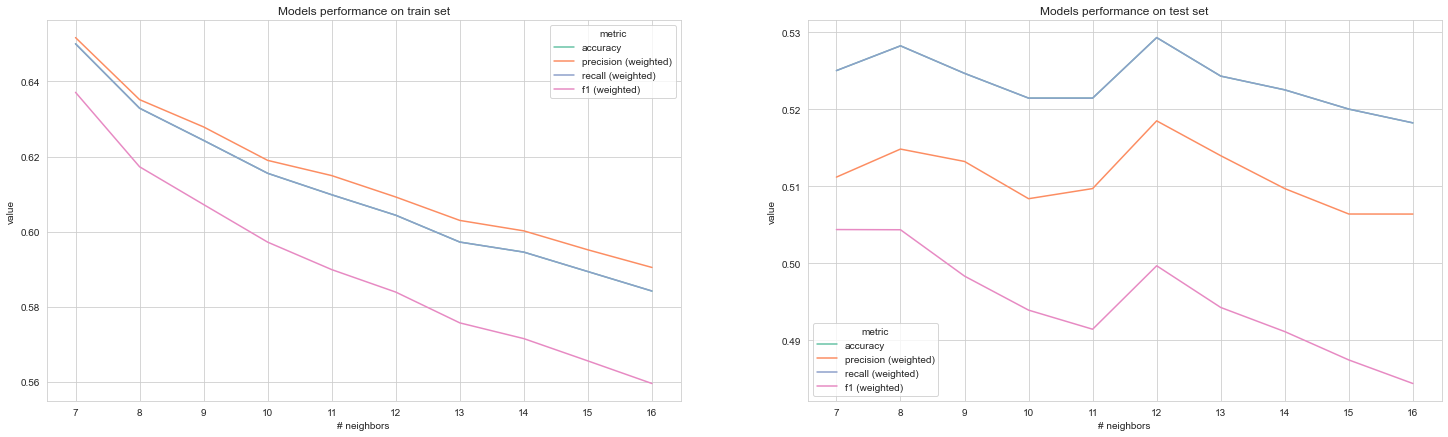

In [26]:
fig, axis = plt.subplots(1, 2, figsize=(25, 7))
sns.lineplot(data=train_set_results, x='# neighbors', y='value', hue='metric', ax=axis[0])
axis[0].set_title('Models performance on train set')
sns.lineplot(data=test_set_results, x='# neighbors', y='value', hue='metric', ax=axis[1])
axis[1].set_title('Models performance on test set')
plt.show()

The model with 8 nearest neighbors seems to be the best performing in terms of f1 score, and the model with 12 nearest neighbors seems to be the best performing in terms of precision and accuracy.

In [27]:
model_evaluations['model_12'].get_scores(on_sets=['train', 'validation'], average_type='weighted')

,train,validation
accuracy,0.604375,0.529286
precision (weighted),0.609226,0.518477
recall (weighted),0.604375,0.529286
f1 (weighted),0.583917,0.499667


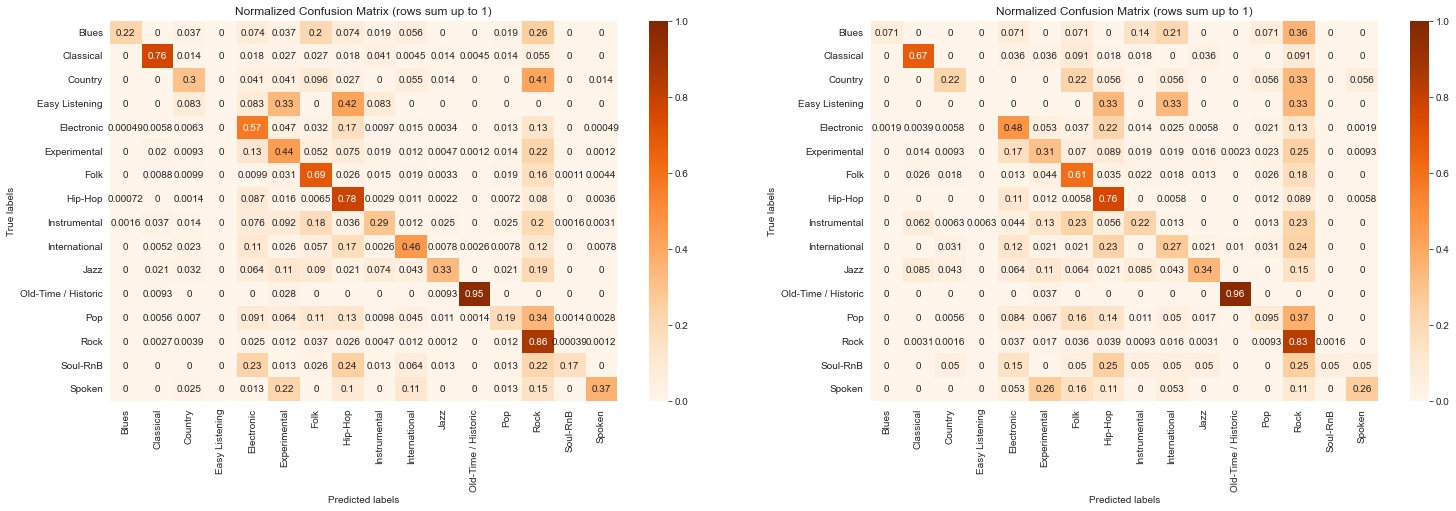

In [28]:
fig, axis = plt.subplots(1, 2, figsize=(25, 7))
fig.suptitle('Confusion matrices on Train (left) and Test (right) sets')
model_evaluations['model_12'].plot_confusion_matrix(ax=axis[0], on_set='train')
model_evaluations['model_12'].plot_confusion_matrix(ax=axis[1], on_set='validation')

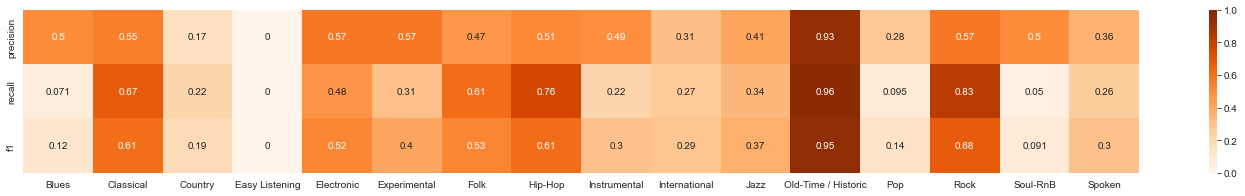

In [52]:
fig, axis = plt.subplots(1, 1, figsize=(25, 3))
model_evaluations['model_12'].plot_metrics_per_class(ax=axis, on_set='validation')

# 4. Training the classifiers on the principal components

In [10]:
# Select the number of components such that the amount of variance that needs to be explained is greater than 95%
pca = PCA(n_components=0.95)

train_X_2, test_X_2 = scale_features(train_X, test_X, StandardScaler())

train_X_2 = pd.DataFrame(pca.fit_transform(train_X_2), index=train_X_2.index)
test_X_2 = pd.DataFrame(pca.transform(test_X_2), index=test_X_2.index)

In [11]:
train_X_2, test_X_2 = scale_features(train_X_2, test_X_2, MinMaxScaler())

In [14]:
distances_train_pca = pd.DataFrame(pairwise_distances(train_X_2, metric='euclidean', n_jobs=-1), index=train_X_2.index, columns=train_X_2.index)

In [15]:
distances_test_pca = pd.DataFrame(pairwise_distances(test_X_2, train_X_2, metric='euclidean', n_jobs=-1), index=test_X_2.index, columns=train_X_2.index)

In [29]:
model_evaluations_pca = {}
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed')
    knn.fit(distances_train_pca, train_y)

    me = ClassificationEvaluation(
        model_name=f'model_{i}',
        model=knn,
        train_X=distances_train_pca,
        train_y=train_y,
        val_X=distances_test_pca,
        val_y=test_y
    )

    model_evaluations_pca[f'model_{i}'] = me

In [30]:
train_set_results_pca, test_set_results_pca, num_neighbors = get_train_test_results(model_evaluations_pca, average_type='weighted')

In [31]:
train_set_results_pca = results_long_format(train_set_results_pca)
test_set_results_pca = results_long_format(test_set_results_pca)

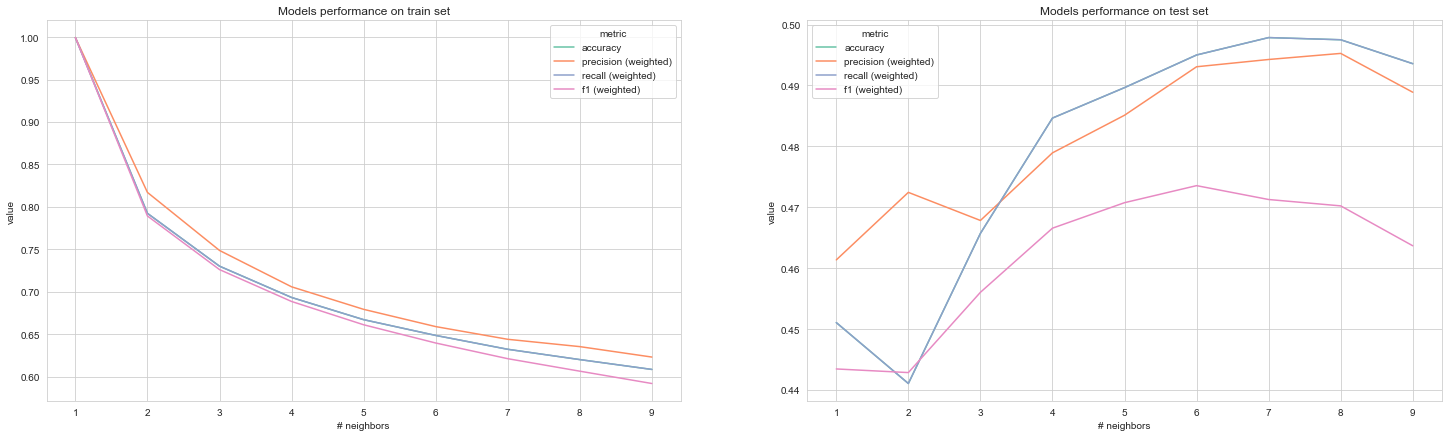

In [32]:
fig, axis = plt.subplots(1, 2, figsize=(25, 7))
sns.lineplot(data=train_set_results_pca, x='# neighbors', y='value', hue='metric', ax=axis[0])
axis[0].set_title('Models performance on train set')
sns.lineplot(data=test_set_results_pca, x='# neighbors', y='value', hue='metric', ax=axis[1])
axis[1].set_title('Models performance on test set')
plt.show()

F1 score is best when k is 6
Precision is best when k is 8
Recall and accuracy are best when k is 7

In [37]:
model_evaluations_pca['model_7'].get_scores(on_sets=['train', 'validation'], average_type='weighted')

,train,validation
accuracy,0.632143,0.497857
precision (weighted),0.643915,0.494261
recall (weighted),0.632143,0.497857
f1 (weighted),0.621070,0.471275


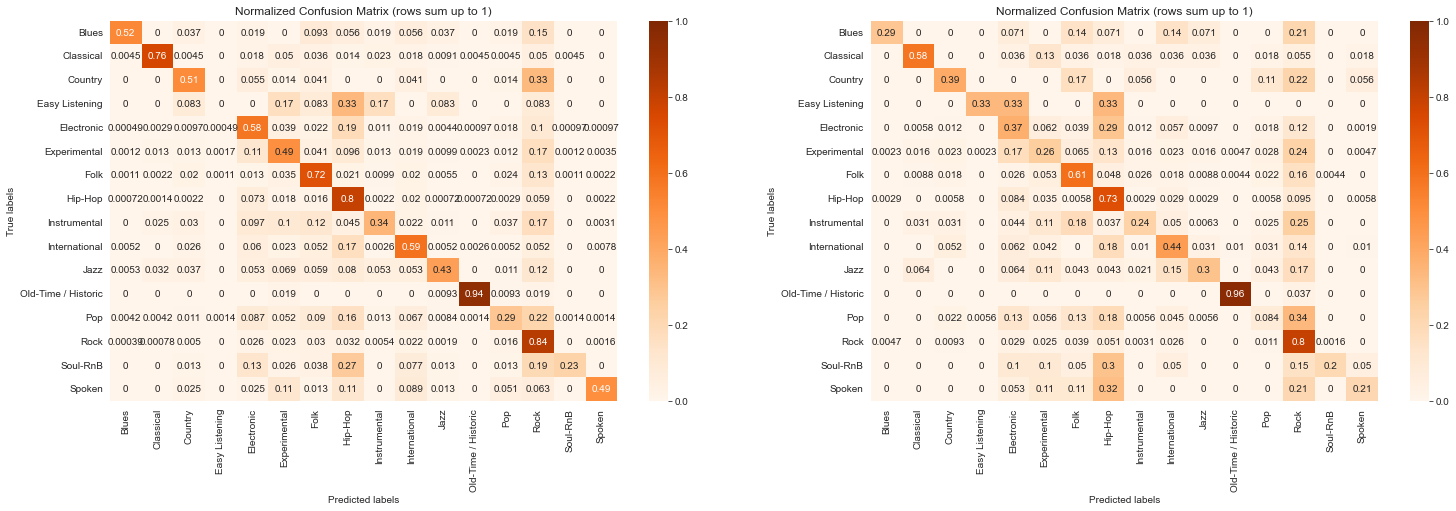

In [34]:
_, axis = plt.subplots(1, 2, figsize=(25, 7))
fig.suptitle('Confusion matrices on Train (left) and Test (right) sets')
model_evaluations_pca['model_7'].plot_confusion_matrix(ax=axis[0], on_set='train')
model_evaluations_pca['model_7'].plot_confusion_matrix(ax=axis[1], on_set='validation')

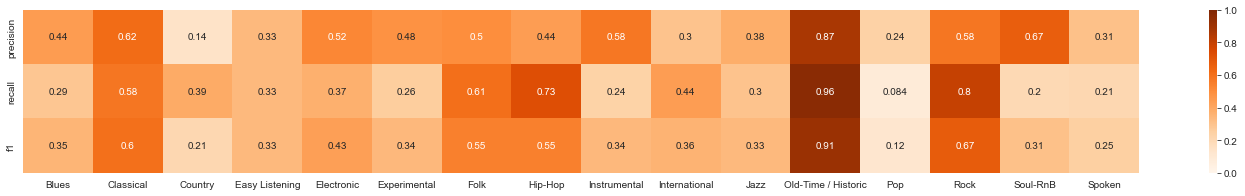

In [35]:
fig, axis = plt.subplots(1, 1, figsize=(25, 3))
model_evaluations_pca['model_7'].plot_metrics_per_class(ax=axis, on_set='validation')


Despite the high dimensionality of the original feature set, the KNN model trained on it performed better than the one trained on the Principal Components that explain 95% of the variance.
To explore potential improvements, we could also try to define a custom proximity measure where we assign different weights on different features (e.g. assign more weight on the MFCC features)